<h3>Time Series</h3>

For time series data, we should pay attention to three characteristics:
- Autocorrelation

Informally, autocorrelation is the similarity between observations as a function of the time lag between them.
<img src="https://miro.medium.com/max/2100/1*F5wTJgw8dpteJssJVGXPcg.png">

Above is an example of an autocorrelation plot. Looking closely, you realize that the first value and the 24th value have a high autocorrelation. Similarly, the 12th and 36th observations are highly correlated. This means that we will find a very similar value at every 24 unit of time.
- Seasonality

Seasonality refers to periodic fluctuations. For example, electricity consumption is high during the day and low during night, or online sales increase during Christmas before slowing down again.
<img src="https://miro.medium.com/max/2100/1*po-ZfwDPLCS5cIQBG_S-lA.png">
- Stationarity

Stationarity is an important characteristic of time series. A time series is said to be stationary if its statistical properties do not change over time. In other words, it has constant mean and variance, and covariance is independent of time.
<img src="https://miro.medium.com/max/2100/1*xwMPhair-k-djWtULbEObQ.png">
Looking again at the same plot, we see that the process above is stationary. The mean and variance do not vary over time.
Often, stock prices are not a stationary process, since we might see a growing trend, or its volatility might increase over time (meaning that variance is changing).

<h3>Modelling</h3>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize

import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

# define the error metrics
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline # to show the plots

UsageError: unrecognized arguments: # to show the plots


In [3]:
# If True and parse_dates is enabled, pandas will attempt to infer the format of the datetime strings in the columns
df = pd.read_csv("stock_prices_sample.csv", index_col = ["DATE"], parse_dates = ['DATE'])
df.head()

,TICKER,FIGI,TYPE,FREQUENCY,OPEN,HIGH,LOW,CLOSE,VOLUME,ADJ_OPEN,ADJ_HIGH,ADJ_LOW,ADJ_CLOSE,ADJ_VOLUME,ADJ_FACTOR,EX_DIVIDEND,SPLIT_RATIO
DATE,,,,,,,,,,,,,,,,,
2013-01-04,GEF,BBG000BLFQH8,EOD,daily,46.31,47.6198,46.23,47.37,248000.0,38.517220,39.606614,38.450681,39.398849,248000.0,NaN,0.0,1.0
2013-01-03,GEF,BBG000BLFQH8,EOD,daily,46.43,46.5200,46.14,46.48,131300.0,38.617027,38.691882,38.375826,38.658613,131300.0,NaN,0.0,1.0
2013-01-02,GEF,BBG000BLFQH8,EOD,daily,45.38,46.5400,45.16,46.41,184900.0,37.743715,38.708516,37.560735,38.600392,184900.0,NaN,0.0,1.0
2018-06-05,GF,BBG000C3C6S2,Intraday,daily,18.86,18.9100,18.87,18.87,10000.0,18.860000,18.910000,18.870000,18.870000,10000.0,NaN,0.0,1.0
2018-06-04,GF,BBG000C3C6S2,EOD,daily,18.86,18.8900,18.79,18.81,39095.0,18.860000,18.890000,18.790000,18.810000,39095.0,NaN,0.0,1.0


In [4]:
# clean the data
df = df[df.TICKER == "GF"]
df = df[df.TYPE == "EOD"]
df = df[["TICKER", "OPEN", "HIGH", "LOW", "CLOSE"]]
df.head()

,TICKER,OPEN,HIGH,LOW,CLOSE
DATE,,,,,
2018-06-04,GF,18.86,18.890,18.7900,18.8100
2018-06-01,GF,18.58,18.760,18.5800,18.7400
2018-05-31,GF,18.52,18.520,18.3012,18.4900
2018-05-30,GF,18.47,18.678,18.4700,18.6500
2018-05-29,GF,18.51,18.510,18.1500,18.2562


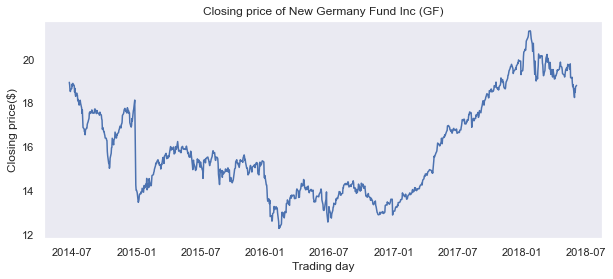

In [22]:
# plot closing price
plt.figure(figsize = (10,4))
plt.plot(df.CLOSE)
plt.title("Closing price of New Germany Fund Inc (GF)")
plt.xlabel("Trading day")
plt.ylabel("Closing price($)")
plt.grid(False)
plt.show()

Moving Average - Testing for stationarity

In [102]:
# calculate the moving average
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):
    
    rolling_mean = series.rolling(window).mean()
    plt.figure(figsize = (10,5))
    plt.plot(rolling_mean.dropna(), label=f"Moving average for {window} days")
    #plt.plot(series.rolling(window).std().dropna(), label=f"Moving Standard for {window} days")
    
    # calculate the confidence intervals (1.96 for 5% confidence level)
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
        
    plt.plot(series[window:], label="Actual values")
    plt.title(f"Moving Average\n window size = {window}")
    plt.legend(loc="best")
    plt.show()

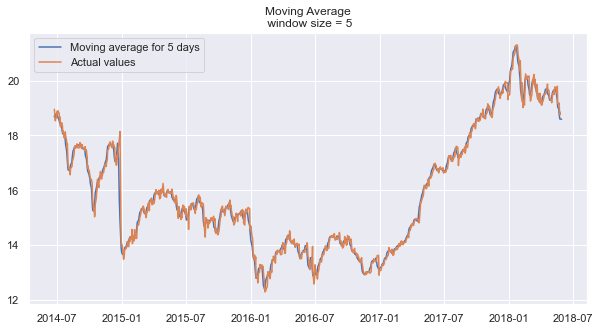

In [103]:
plot_moving_average(df["CLOSE"], 5)

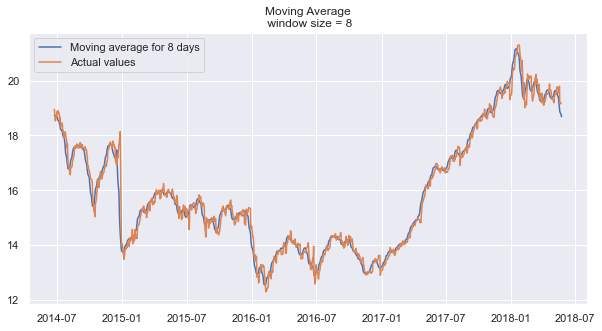

In [104]:
plot_moving_average(df.CLOSE, 8)

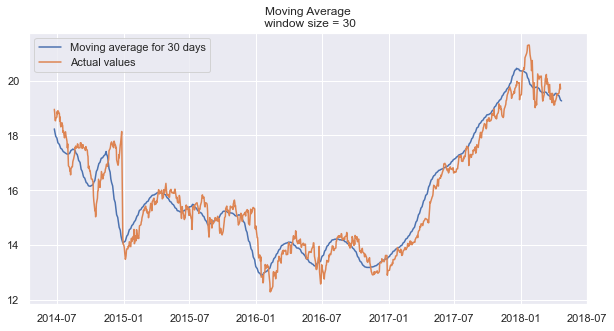

In [105]:
plot_moving_average(df.CLOSE, 30)

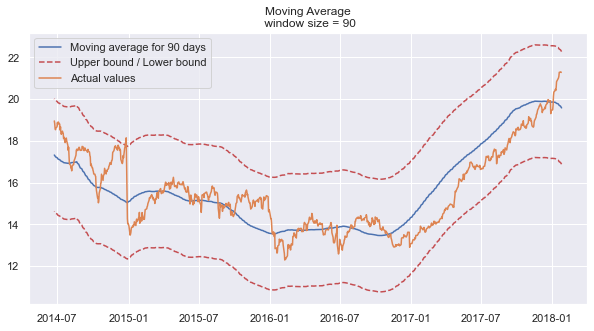

In [77]:
plot_moving_average(df.CLOSE, 90, plot_intervals=True)

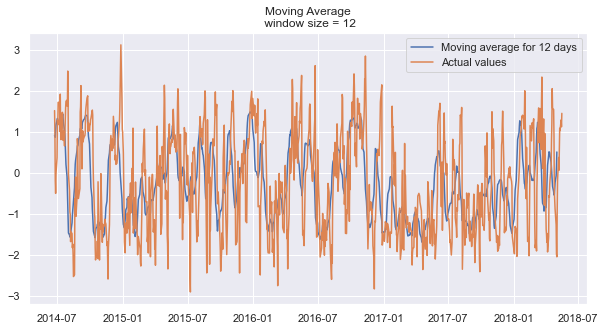

In [110]:
df["de_trend"] = (df["CLOSE"] - df["CLOSE"].rolling(12).mean())/df["CLOSE"].rolling(12).std()
plot_moving_average(df["de_trend"],12)

In [106]:
from statsmodels.tsa.stattools import adfuller

print(" > Is the data stationary ?")
dftest = adfuller(df.CLOSE, autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

 > Is the data stationary ?
Test statistic = -1.472
P-value = 0.547
Critical values :
	1%: -3.43694584277544 - The data is not stationary with 99% confidence
	5%: -2.8644520725172873 - The data is not stationary with 95% confidence
	10%: -2.5683205291305176 - The data is not stationary with 90% confidence


In [107]:
dftest

(-1.4716627443578203,
 0.5474799186884562,
 0,
 994,
 {'1%': -3.43694584277544,
  '5%': -2.8644520725172873,
  '10%': -2.5683205291305176},
 -315.217499339027)

Exponential Smoothing: alpha * yt + (1 - alpha) * yt-1

In [88]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for i in range(1, len(series)):
        result.append(alpha * series[i] + (1 - alpha) * result[i-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
    plt.figure(figsize=(10,5))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual") # because the values calculated is used normal index, instead datetime
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")

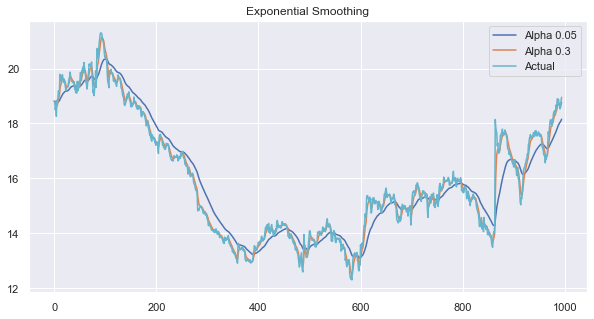

In [89]:
plot_exponential_smoothing(df.CLOSE, [0.05,0.3])

Double exponential smoothing

In [90]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(10, 5))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.title("Double Exponential Smoothing")

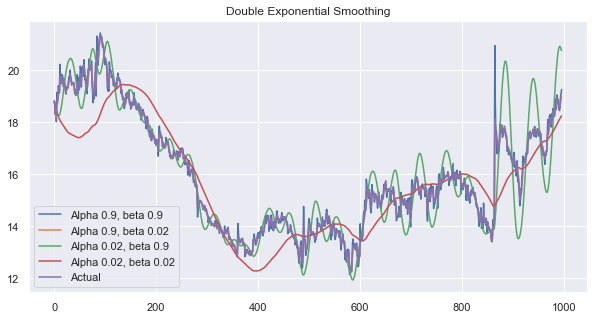

In [91]:
plot_double_exponential_smoothing(df.CLOSE, alphas=[0.9, 0.02], betas=[0.9, 0.02])

ARIMA

Refer to: https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788

ARIMA models (which include ARMA, AR and MA models) are a general class of models to forecast stationary time series. ARIMA models are made of three parts:
- A weighted sum of lagged values of the series (Auto-regressive (AR) part)
- A weighted sum of lagged forecasted errors of the series (Moving-average (MA) part)
- A difference of the time series (Integrated (I) part)

An ARIMA model is often noted ARIMA(p, d, q) where p represents the order of the AR part, d the order of differencing (“I” part), and q the order of the MA term.

1) Choosing the differencing order

The first step of fitting an ARIMA model is to determine the differencing order to stationarize the series. To do that, we look at the ACF and PACF plots, and keep in mind these two rules:
- Rule 1 : If the series has positive autocorrelations out to a high number of lags, then it probably needs a higher order of differencing.
- Rule 2 : If the lag-1 autocorrelation is zero or negative, or the autocorrelations are all small and patternless, then the series does not need a higher order of differencing. If the lag-1 autocorrelation is -0.5 or more negative, the series may be overdifferenced.”

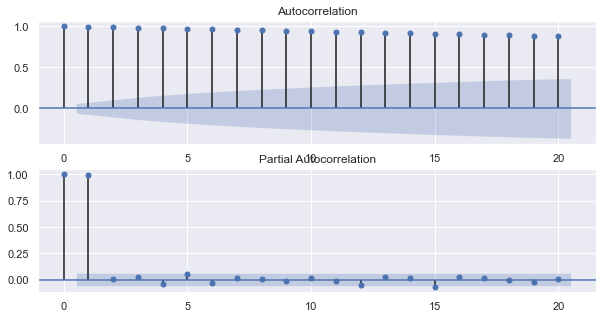

In [112]:
# Autocorrelation and partial Autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(10,5))
ax[0] = plot_acf(df.CLOSE.dropna(), ax=ax[0], lags=20)
ax[1] = plot_pacf(df.CLOSE.dropna(), ax=ax[1], lags=20)

The “Autocorrelation” chart shows non-stationary data, characterized by the slow linear decay in the spikes (cf rule 1 above)

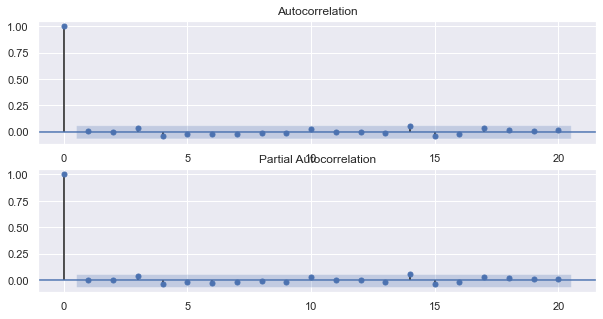

In [119]:
fig, ax = plt.subplots(2, figsize=(10,5))
ax[0] = plot_acf((df.CLOSE - df.CLOSE.shift()).dropna(), ax=ax[0], lags=20)
ax[1] = plot_pacf((df.CLOSE - df.CLOSE.shift()).dropna(), ax=ax[1], lags=20)

                              ARMA Model Results                              
Dep. Variable:                  CLOSE   No. Observations:                  995
Model:                     ARMA(0, 0)   Log Likelihood               -2182.269
Method:                           css   S.D. of innovations              2.169
Date:                Wed, 02 Dec 2020   AIC                           4368.538
Time:                        21:24:54   BIC                           4378.343
Sample:                             0   HQIC                          4372.265
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.9136      0.069    231.424      0.000      15.779      16.048
                             ARIMA Model Results                              
Dep. Variable:                D.CLOSE   No. Observat

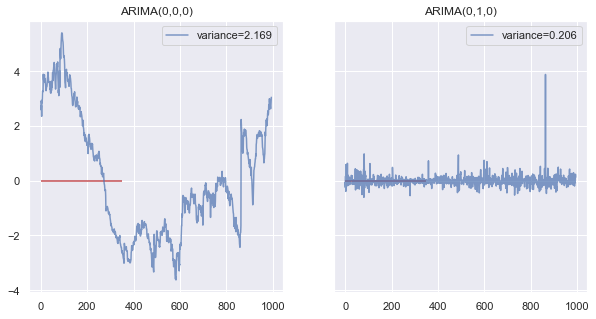

In [5]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df.CLOSE.dropna(), (0, 0, 0))
res_000 = model.fit()
print(res_000.summary())

model = ARIMA(df.CLOSE.dropna(), (0, 1, 0))
res_010 = model.fit()
print(res_010.summary())

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10,5))
ax[0].plot(res_000.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_000.resid.values)));
ax[0].hlines(0, xmin=0, xmax=350, color='r');
ax[0].set_title("ARIMA(0,0,0)");
ax[0].legend();
ax[1].plot(res_010.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_010.resid.values)));
ax[1].hlines(0, xmin=0, xmax=350, color='r');
ax[1].set_title("ARIMA(0,1,0)");
ax[1].legend();

The Akaike Information Criterion (AIC) is lower with the ARIMA(0,1,0), meaning this model is performing better than the ARIMA(0,0,0).

2) Choosing the MA order

If the lag-1 autocorrelation of the differenced series (because it is stationary) ACF is negative, and/or there is a sharp cutoff, then choose a MA order of 1.

如果autocorrelation拖尾，diff(1)之后截尾，那么ma取0或者1。

                             ARIMA Model Results                              
Dep. Variable:                D.CLOSE   No. Observations:                  994
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 157.885
Method:                           css   S.D. of innovations              0.206
Date:                Wed, 02 Dec 2020   AIC                           -311.770
Time:                        20:28:48   BIC                           -301.966
Sample:                             1   HQIC                          -308.043
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.007      0.022      0.983      -0.013       0.013
                             ARIMA Model Results                              
Dep. Variable:                D.CLOSE   No. Observat

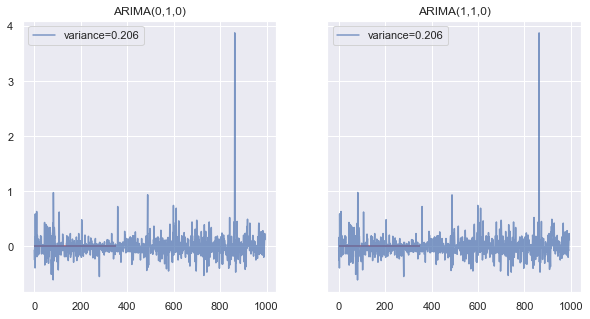

In [122]:
model = ARIMA(df.CLOSE.dropna(), (0, 1, 0))
res_010 = model.fit()
print(res_010.summary())

model = ARIMA(df.CLOSE.dropna(), (1, 1, 0))
res_110 = model.fit()
print(res_110.summary())

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10,5))
ax[0].plot(res_010.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_010.resid.values)));
ax[0].hlines(0, xmin=0, xmax=350, color='r');
ax[0].set_title("ARIMA(0,1,0)");
ax[0].legend();
ax[1].plot(res_110.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_110.resid.values)));
ax[1].hlines(0, xmin=0, xmax=350, color='r');
ax[1].set_title("ARIMA(1,1,0)");
ax[1].legend();

AIC increased a little bit, which indicates that the combination of 0,1,0 is better.

3) Choosing the AR order

If the lag-1 autocorrelation of the differenced series PACF is negative, and/or there is a sharp cutoff, then choose a AR order of 1。具体看什么时候截尾。然后取相近的数。

                             ARIMA Model Results                              
Dep. Variable:                D.CLOSE   No. Observations:                  994
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 157.885
Method:                           css   S.D. of innovations              0.206
Date:                Wed, 02 Dec 2020   AIC                           -311.770
Time:                        20:33:16   BIC                           -301.966
Sample:                             1   HQIC                          -308.043
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.007      0.022      0.983      -0.013       0.013
                             ARIMA Model Results                              
Dep. Variable:                D.CLOSE   No. Observat

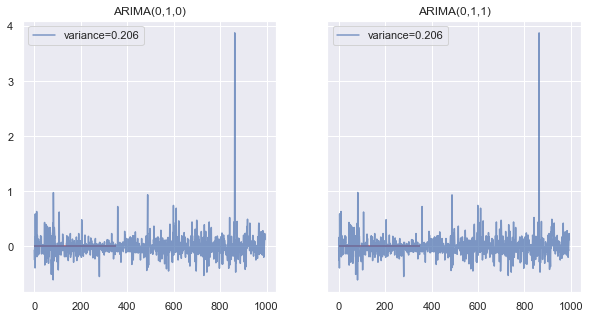

In [129]:
model = ARIMA(df.CLOSE.dropna(), (0, 1, 0))
res_010 = model.fit()
print(res_010.summary())

model = ARIMA(df.CLOSE.dropna(), (0, 1, 1))
res_011 = model.fit()
print(res_011.summary())

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10,5))
ax[0].plot(res_010.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_010.resid.values)));
ax[0].hlines(0, xmin=0, xmax=350, color='r');
ax[0].set_title("ARIMA(0,1,0)");
ax[0].legend();
ax[1].plot(res_011.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_011.resid.values)));
ax[1].hlines(0, xmin=0, xmax=350, color='r');
ax[1].set_title("ARIMA(0,1,1)");
ax[1].legend();

AIC increased a little bit, which indicates that the combination of 0,1,0 is better.

Prediction https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

In [6]:
train = df["CLOSE"][:int(len(df["CLOSE"]) * 0.8)]
test = df["CLOSE"][int(len(df["CLOSE"]) * 0.8):]

Test MSE: 0.105
The Accuracy: 99.36%


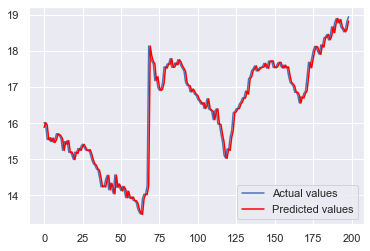

In [8]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
print(f'The Accuracy: {(1 - error/test.mean())*100:.2f}%')
# plot
plt.plot(test.values, label="Actual values")
plt.plot(predictions, color='red', label="Predicted values")
plt.legend()
plt.show()

Decomposition: trend + seasonality + residual (prediction based on policy trend and past experiences)

A time series can be thought of as being made up of 4 components: A seasonal component, A trend component, A cyclical component, and A noise component.

Refer to: https://towardsdatascience.com/what-is-time-series-decomposition-and-how-does-it-work-9b67e007ae90

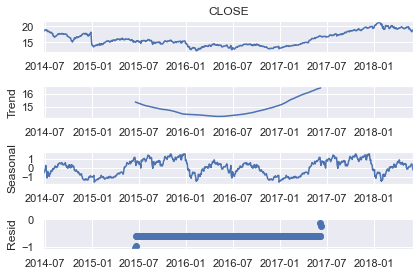

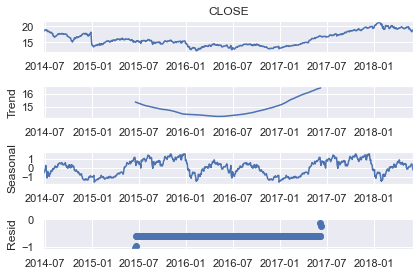

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

components = seasonal_decompose(df['CLOSE'], period=int(len(df)/2))
components.plot()

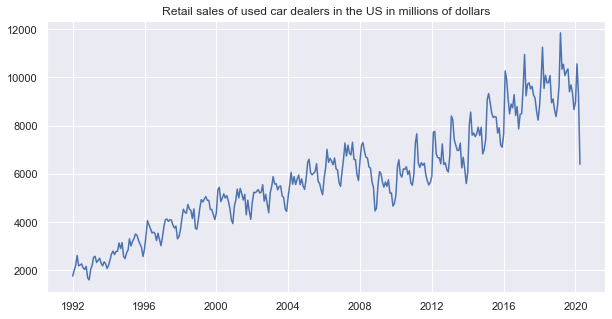

In [24]:
# Testing for a new dataset
# The trend component - centered moving average
mydateparser = lambda x: pd.datetime.strptime(x, "%d-%m-%y")
data = pd.read_csv("retail_sales_used_car_dealers_us_1992_2020.csv", header = 0, index_col=0, 
                   parse_dates=['DATE'], date_parser=mydateparser)
data.head()

plt.figure(figsize=(10,5))
plt.plot(data.Retail_Sales)
plt.title("Retail sales of used car dealers in the US in millions of dollars")
plt.show()

STEP 1: Try to guess the duration of the seasonal component in your data. In the above example, we’ll guess it to be 12 months.

STEP 2: Now run a 12 month centered moving average on the data. This moving average is spread across a total of 13 months. i.e. 6 months each on the left and right side of the center month. The 12 month centered MA is an average of two moving averages that are shifted from each other by 1 month, effectively making it a weighted moving average.

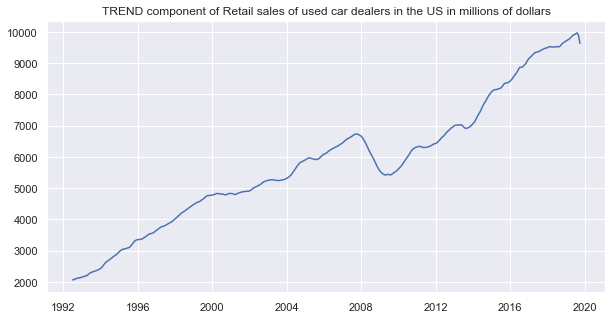

In [26]:
# assign one column for the trend component
data["trend"] = np.nan
data["ma_12"] = data["Retail_Sales"].rolling(12).mean()
for i in range(6, len(data)-6):
    data["trend"][i] = (data["ma_12"][i+5] + data["ma_12"][i+6])/2

# plot the trend
plt.figure(figsize=(10,5))
plt.plot(data["trend"])
plt.title("TREND component of Retail sales of used car dealers in the US in millions of dollars")
plt.show()

STEP 3: Now we have a decision to make. Depending on whether the composition is multiplicative or additive, we’ll need to divide or subtract the trend component from the original time series to retrieve the seasonal and noise components. If we inspect the original car sales time series, we can see that the seasonal swings are increasing in proportion to the current value of the time series. Hence we’ll assume that the seasonality is multiplicative. We’ll also take a small leap of faith to assume that the noise is multiplicative.

Thus the retail used car sales time series is assumed to have the following multiplicative decomposition model:
Time series value = trend component * seasonal component * noise component

Therefore:
seasonal component * noise component = Time series value / trend component


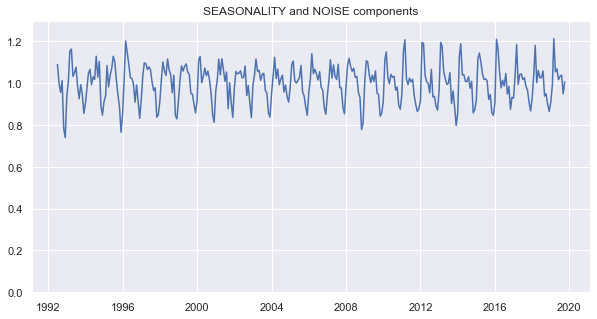

In [91]:
# Seasonality and noise component
data["Seasonality and noise"] = data["Retail_Sales"]/data["trend"]

# plot
plt.figure(figsize=(10,5))
plt.plot(data["Seasonality and noise"])
plt.ylim(0, 1.3)
plt.title("SEASONALITY and NOISE components")
plt.show()

STEP 4: Next, we will get the ‘pure’ seasonal component out of the mixture of seasonality and noise, by calculating the average value of the seasonal component for all January months, all February months, all March months and so on.

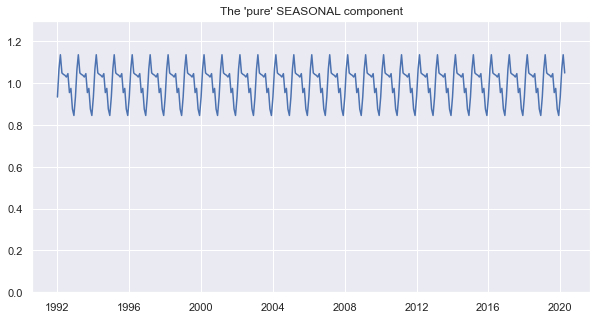

In [90]:
data["Month"] = data.index.strftime("%m").astype(np.int)
data["seasonality"] = 0

# conditional change一定要用loc！！！！！
for i in range(1,13):
    data.loc[data["Month"]==i, "seasonality"] = data[data["Month"]==i]["Seasonality and noise"].dropna().mean()

data.head(10)

# plot
plt.figure(figsize=(10,5))
plt.plot(data["seasonality"])
plt.ylim(0, 1.3)
plt.title("The 'pure' SEASONAL component")
plt.show()

STEP 5: Finally, we will divide the noisy seasonal value that we had isolated earlier with the averaged out seasonal value to yield just the noise component for each month.

noise component = noisy seasonal component / averaged out seasonal component

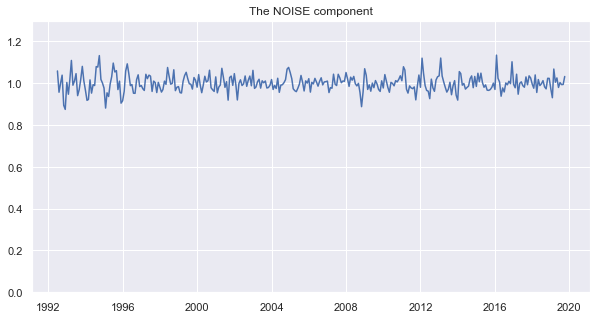

In [92]:
data["noise"] = data["Seasonality and noise"]/data["seasonality"]

# plot
plt.figure(figsize=(10,5))
plt.plot(data["noise"])
plt.ylim(0, 1.3)
plt.title("The NOISE component")
plt.show()

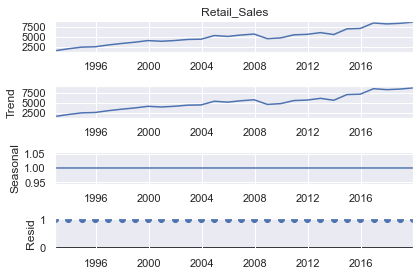

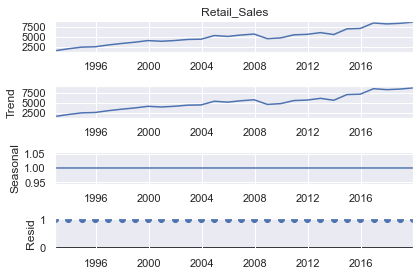

In [93]:
from statsmodels.tsa.seasonal import seasonal_decompose
components = seasonal_decompose(df['Retail_Sales'], model='multiplicative')
components.plot()